In [6]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 100)
plt.style.use('ggplot')

#Might have to check how files are being imported
df = pd.read_csv('NFL Play by Play 2009-2016 (v3).csv')
#df.head()

## Initial Investigation

In [10]:
df['GameID']=df['GameID'].astype(int)

Tie Games: 2014101202, 2012111110, 2013112403, 2016102312, 2016103000

In [12]:
df_cleaned = df.drop(columns=['desc','yrdln','PlayTimeDiff','time','Date','SideofField',
                              'PlayAttempted','DefTwoPoint','Passer','Passer_ID','PassLength','PassLocation','Interceptor',
                              'Rusher','Rusher_ID','RunLocation','RunGap','Receiver','Receiver_ID','Returner',
                              'BlockingPlayer','Tackler1','Tackler2','RecFumbTeam','RecFumbPlayer','PenalizedTeam',
                              'PenaltyType','PenalizedPlayer','Timeout_Team','PassAttempt',
                              'PassOutcome','AirYards','YardsAfterCatch','QBHit','RushAttempt','Reception','Fumble','Sack',
                             'Challenge.Replay','ChalReplayResult','Accepted.Penalty','Timeout_Indicator',
                             'posteam_timeouts_pre', 'yacWPA', 'airWPA', 'airEPA', 'yacEPA'])

## Appending Game Results to each Row

In [14]:
df_result = df_cleaned.loc[:,['GameID','posteam','DefensiveTeam','PlayType','PosTeamScore','DefTeamScore',
                           'ScoreDiff','HomeTeam', 'AwayTeam']]
#df_result[df_result['PlayType']=='End of Game'].head(10)

In [16]:
winning_teams=[]
losing_teams=[]
tying_teams =[]
for index,row in df_result.iterrows():
    if row['PlayType'] =='End of Game' and row['ScoreDiff']>0:
        winning_teams.append((row['GameID'],row['posteam']))
        losing_teams.append((row['GameID'],row['DefensiveTeam']))
    elif row['PlayType'] =='End of Game' and row['ScoreDiff']<0:
        winning_teams.append((row['GameID'],row['DefensiveTeam']))
        losing_teams.append((row['GameID'],row['posteam']))
    else:
        tying_teams.append((row['GameID'],row['HomeTeam']))

In [18]:
#df_cleaned['result'] = np.NaN
winning_teams = dict(winning_teams)
losing_teams = dict(losing_teams)
tying_teams = dict(tying_teams)

In [19]:
result_list = []
for index, row in df_result.iterrows():
    if (row['GameID'] in winning_teams.keys()):
        if (row['posteam']==winning_teams[row['GameID']]):
            result_list.append('W')
    if (row['GameID'] in losing_teams.keys()):
        if (row['posteam']==losing_teams[row['GameID']]):
            result_list.append('L')
    elif (row['GameID'] in tying_teams.keys()):
        if pd.notnull(row['posteam']):
            result_list.append('T')

In [23]:
df_result.loc[(pd.notnull(df_result['posteam'])),'result']=result_list

In [24]:
df_cleaned.loc[(pd.notnull(df_cleaned['posteam'])),'result']=result_list

In [32]:
plays = ['Pass','Run','Sack','QB Kneel','Spike','Field Goal']
df_filtered = df_cleaned[(df_cleaned['PlayType'].isin(plays))]
df_filtered = df_filtered[(pd.isna(df_filtered['TwoPointConv'])) & 
                          (df_filtered['Onsidekick']==0) & 
                         ~(pd.isna(df_filtered['down'])) ]
df_filtered = df_filtered[df_filtered['TimeSecs'] > 0]
dropped_cols = ['DefensiveTeam','PuntResult','Onsidekick','ExPointResult','sp',
                'TimeUnder','TwoPointConv','ReturnResult','PosTeamScore',
                'DefTeamScore','AbsScoreDiff','No_Score_Prob','Opp_Field_Goal_Prob',
                'Opp_Safety_Prob','Opp_Field_Goal_Prob','Touchdown_Prob','ExPoint_Prob','TwoPoint_Prob','ExpPts',
                'EPA','WPA','Opp_Safety_Prob','Opp_Touchdown_Prob','Win_Prob','Home_WP_pre',
                'Away_WP_pre', 'Field_Goal_Prob', 'Safety_Prob', 'PlayType', 'Drive', 'Yards.Gained']
df_filtered = df_filtered.drop(columns=dropped_cols)
df_filtered = df_filtered[df_filtered['result'] != 'T']

In [36]:
df_filtered.FieldGoalDistance = df_filtered.FieldGoalDistance.fillna(0)
df_filtered.FieldGoalResult = df_filtered.FieldGoalResult.fillna(0)

print("Checking field goal data: ")
df_filtered.FieldGoalResult.value_counts()

Checking field goal data: 


0          214861
Good         5290
No Good       840
Blocked       133
Name: FieldGoalResult, dtype: int64

In [37]:
field_goal_df = pd.DataFrame(df_filtered.FieldGoalResult)
field_goal_df = pd.get_dummies(field_goal_df, drop_first=True)
df_filtered = df_filtered.drop(columns=['FieldGoalResult'])
df_filtered = df_filtered.join(field_goal_df)

In [38]:
df_filtered['scorediff_divsecs'] = df_filtered.ScoreDiff/(df_filtered.TimeSecs + 0.01)

## Splitting Training and Testing Sets

In [39]:
Train = df_filtered[df_filtered['Season'].isin([2009, 2010, 2011, 2012, 2013, 2014, 2015])]
Test = df_filtered[df_filtered['Season']==2016]
print(Train.shape)
print(Test.shape)

(193982, 30)
(27142, 30)


## Initial Model Buidling

## Random Forest

### Stage 1.

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#features = df_filtered.drop(columns=['result', 'Season'])
#outcome = df_filtered.result
#X_train, X_test, y_train, y_test = train_test_split(features, outcome, test_size=0.25)
y_train = Train.result
X_train = Train.drop(columns=['result'])
y_test = Test.result
X_test = Test.drop(columns=['result'])
 

X_train_identifiers = X_train[['GameID', 'HomeTeam', 'AwayTeam', 'Home_WP_post', 'Away_WP_post', 'posteam', 'Season']].copy()
X_test_identifiers = X_test[['GameID', 'HomeTeam', 'AwayTeam','Home_WP_post','Away_WP_post', 'posteam', 'Season']].copy()
X_train = X_train.drop(columns=['GameID', 'HomeTeam', 'AwayTeam','Home_WP_post','Away_WP_post', 'posteam','Season'])
X_test = X_test.drop(columns=['GameID', 'HomeTeam', 'AwayTeam','Home_WP_post','Away_WP_post', 'posteam','Season'])

random_forest_classifier = RandomForestClassifier(n_estimators=200, 
                                                  criterion='entropy', 
                                                  n_jobs=-1, 
                                                  random_state=42, 
                                                  max_depth=10)

random_forest_classifier.fit(X_train, y_train)




RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [67]:
prediction_train = random_forest_classifier.predict(X_train)
prediction_test = random_forest_classifier.predict(X_test)

In [69]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

In [70]:
df_test = df_filtered.copy()
train_probs = random_forest_classifier.predict_proba(X_train)
test_probs = random_forest_classifier.predict_proba(X_test)

# probs_to_keep = []
# for i in range(full_probs.shape[0])):
#     if(df_test.result==)
# full_probs = np.append(train_probs[:,1],test_probs[:,1])
# #full_probs = train_probs[:,1]
# df_test['pred_win_prob'] = full_probs
# df_test['predicted_outcome'] = np.append(prediction_train,prediction_test)



In [71]:
def createWeightMatrixWithTimes(number_of_weights=4,buffer_time=7.5,game_duration=60,equal_weight=False):
    game_duration=60*game_duration
    buffer_time=buffer_time*60
    #weight magnitude is merely 2/[(n)*(n+1)]
    
    if(equal_weight==False):
        weight_magnitude = 2/((number_of_weights)*(number_of_weights+1))
    else:
        weight_magnitude = 1/number_of_weights
    weight_vector = []
    weight_times = []
    
    for i in range(0,number_of_weights):
        if(equal_weight==False):
            weight_vector.append((i+1)*weight_magnitude)
        else:
            weight_vector.append(weight_magnitude)
        weight_times.append(buffer_time+(i*(game_duration-buffer_time*2))/(number_of_weights-1))
        
    return(weight_vector,weight_times[::-1])

In [73]:
def getWinProbsPredicted(masterDataFrame, offset_time, num_weights):
    
    weighting_scheme,weights = createWeightMatrixWithTimes(number_of_weights=num_weights,buffer_time=offset_time,equal_weight=False)

    game_ID_list = np.unique(masterDataFrame.GameID)

    result_df = pd.DataFrame()
    
    master_list = []
    
    #Append Predicted win probability to the data frame

    no_add_to_list_flag = 0
    for gm_ID in game_ID_list:
        game_frame = masterDataFrame[masterDataFrame["GameID"]==gm_ID].reset_index(drop=True)
        #If we have a valid game frame gather probabilities
        
        if(~game_frame.empty):
            home_team_win = []
            
            for i in weights:
                temp_val2 = game_frame[game_frame["TimeSecs"]<=i].index
                temp_val = temp_val2[0]
                
                #Need to roll back to previous timestamp if the weighted sampling time isn't matching the play start time
                if(game_frame["TimeSecs"][temp_val] != i):
                    temp_val=temp_val-1
                win_prob = game_frame.iloc[temp_val]["pred_win_prob"]
                
                home_team_win.append(win_prob)
                
                #Invalid win probability detected!
                if(not (win_prob <= 1 and win_prob >= 0)):
                    no_add_to_list_flag=1
        
        if(no_add_to_list_flag==0):
            subset_for_hometeam_has_ball = game_frame[game_frame.posteam==game_frame.HomeTeam]
            #result_of_game = list(set(subset_for_hometeam_has_ball.result))[0]
            result_of_game = game_frame.predicted_outcome.iloc[0]
            list_to_add = [x for x in home_team_win]
            list_to_add.append(subset_for_hometeam_has_ball.iloc[0].GameID)
            list_to_add.append(result_of_game)

            master_list.append(list_to_add)
        #Reset valid flag back to 0
        else:
            no_add_to_list_flag=0
        
        
    result_df = pd.DataFrame(master_list)
    
    if(result_df.shape[0] > 0):
        names = result_df.columns 
        nameList = []
        for i in range(len(names)-2):
            nameList.append("probability sample: " + str(i+1))
        nameList.append("GameID")
        nameList.append("Home Team Result")

        result_df.columns = nameList

        filename = "our_results_with_timeOffSetOf_"+str(offset_time)+"_and_number_samples_of_"+str(num_weights)+".csv"
        result_df.to_csv(filename, sep=',', encoding='utf-8',index=False)
        return(result_df)
    else:
        return(None)
            
         

In [74]:
df_test=df_filtered

In [102]:
df_test[df_test.GameID==2017010104].head(10)

,GameID,qtr,down,TimeSecs,yrdline100,ydstogo,ydsnet,GoalToGo,FirstDown,posteam,Touchdown,Safety,InterceptionThrown,FieldGoalDistance,Penalty.Yards,ScoreDiff,HomeTeam,AwayTeam,HomeTimeouts_Remaining_Pre,AwayTimeouts_Remaining_Pre,HomeTimeouts_Remaining_Post,AwayTimeouts_Remaining_Post,Home_WP_post,Away_WP_post,Season,result,FieldGoalResult_Blocked,FieldGoalResult_Good,FieldGoalResult_No Good,scorediff_divsecs
361048,2017010104,1,1.0,3600.0,75.0,10,4,0.0,0.0,NE,0,0,0,0.0,0,0.0,MIA,NE,3,3,3,3,0.501802,0.498198,2016,W,0,0,0,0.0
361049,2017010104,1,2.0,3580.0,71.0,6,75,0.0,0.0,NE,0,0,0,0.0,0,0.0,MIA,NE,3,3,3,3,0.541726,0.458274,2016,W,0,0,0,0.0
361051,2017010104,1,3.0,3520.0,71.0,6,10,0.0,1.0,NE,0,0,0,0.0,0,0.0,MIA,NE,3,2,3,2,0.480423,0.519577,2016,W,0,0,0,0.0
361052,2017010104,1,1.0,3481.0,65.0,10,11,0.0,0.0,NE,0,0,0,0.0,0,0.0,MIA,NE,3,2,3,2,0.496443,0.503557,2016,W,0,0,0,0.0
361053,2017010104,1,2.0,3458.0,64.0,9,17,0.0,0.0,NE,0,0,0,0.0,0,0.0,MIA,NE,3,2,3,2,0.486699,0.513301,2016,W,0,0,0,0.0
361054,2017010104,1,3.0,3407.0,58.0,3,37,0.0,1.0,NE,0,0,0,0.0,0,0.0,MIA,NE,3,2,3,2,0.414134,0.585866,2016,W,0,0,0,0.0
361055,2017010104,1,1.0,3365.0,38.0,10,42,0.0,0.0,NE,0,0,0,0.0,0,0.0,MIA,NE,3,2,3,2,0.413051,0.586949,2016,W,0,0,0,0.0
361056,2017010104,1,2.0,3328.0,33.0,5,46,0.0,0.0,NE,0,0,0,0.0,0,0.0,MIA,NE,3,2,3,2,0.407394,0.592606,2016,W,0,0,0,0.0
361057,2017010104,1,3.0,3296.0,29.0,1,50,0.0,1.0,NE,0,0,0,0.0,0,0.0,MIA,NE,3,2,3,2,0.391583,0.608417,2016,W,0,0,0,0.0
361058,2017010104,1,1.0,3263.0,25.0,10,61,0.0,1.0,NE,0,0,0,0.0,0,0.0,MIA,NE,3,2,3,2,0.378802,0.621198,2016,W,0,0,0,0.0


In [103]:
probabilities = random_forest_classifier.predict_proba(X_test)
prob_df = pd.DataFrame(probabilities[:,0], columns=['predicted_win_prob'])
game_prob_df = pd.DataFrame(X_test_identifiers)
game_prob_df['pred_win_prob'] = prob_df.as_matrix()
game_prob_df['TimeSecs'] = X_test['TimeSecs']
game_prob_df = game_prob_df.sort_values(by=['GameID', 'TimeSecs'], ascending=False)
#game_prob_df.head(10)
test_game1  = game_prob_df[(game_prob_df['GameID']== 2017010115) & (game_prob_df['posteam']=='SEA')]


In [78]:
def visualizeAlgorithm(game_frame,offset,samples,pred=False):
    
    if(pred==False):
        htwp=game_frame.Home_WP_post
    else:
        htwp=game_frame.pred_win_prob
        
    print(htwp)
        
    time=game_frame.TimeSecs
    time=3600-time
    
    print(time)
    
    plt.figure(figsize=(10,10))
    plt.plot(time,htwp)
  
    home_team = game_frame.HomeTeam.iloc[0]
    away_team = game_frame.AwayTeam.iloc[0]
    season = game_frame.Season.iloc[0]
    
    game_dur=3600-2*offset*60

    for i in reversed(range(samples)):
        x_val = offset*60+i*game_dur/(samples-1)
        x1 = np.repeat(x_val,1000000)
        y1 = np.linspace(0, 1, 1000000)

        idx = find_nearest(time,x_val)
        idx2 = find_nearest(x1,htwp[idx])
        idx3 = find_nearest(y1,htwp[idx])

        plt.plot(x1[0:idx3],y1[0:idx3],c="blue",alpha=1)
        plt.plot(x1[0], [idx], c="black", marker="x",markersize=200/samples)

    stringy = "\n" + home_team + " (home team) and " + away_team + " (away team) in the " + str(season) + " season"
    stringy2 = "\n" + "Offset time: " + str(offset) + " and number of probability weights: " + str(samples)
    
    print(stringy)
    plt.title("Graph of win probability of a randomly chosen game between: "+stringy+stringy2,fontsize=24)
    plt.xlabel("Time elapsed in game measured in seconds",fontsize=24)
    plt.ylabel("Win probability for home team",fontsize=24)

    xval_sep = np.linspace(1, 60*offset-5, 100)
    xval_sep_end = np.linspace(3600-60*offset+5, 3600, 100)

    for i in range(0,100):
        plt.plot((0,offset*60),(i/100,i/100),c="black",alpha=.15)
        plt.plot((3600-offset*60,3600),(i/100,i/100),c="black",alpha=.15)

        plt.plot((xval_sep[i],xval_sep[i]),(0,1),c="black",alpha=.15)
        plt.plot((xval_sep_end[i],xval_sep_end[i]),(0,1),c="black",alpha=.15)
    
    #linewidth=7.0
    plt.plot((0,3600),(.5,.5),linewidth=5,c="orange")


In [79]:

away_team = game_prob_df[game_prob_df['GameID']== 2016091108].AwayTeam.iloc[0]
test_game1  = game_prob_df[(game_prob_df['GameID']== 2016091108) & (game_prob_df['posteam']==away_team)]


In [80]:
feature_importances = random_forest_classifier.feature_importances_
feature_df = pd.DataFrame(feature_importances, columns=['Importance'])
feature_df['Cols'] = X_train.columns
prediction = random_forest_classifier.predict(X_test)
print('Test Accuracy Rate: ',round(accuracy_score(y_test, prediction),3))

Test Accuracy Rate:  0.776


In [85]:
prob_df = pd.DataFrame(probabilities[:,0], columns=['predicted_win_prob'])
game_prob_df = pd.DataFrame(X_test_identifiers)
game_prob_df['predicted_win_prob'] = prob_df.as_matrix()
game_prob_df['TimeSecs'] = X_test['TimeSecs']
game_prob_df = game_prob_df.sort_values(by=['GameID', 'TimeSecs'], ascending=False)

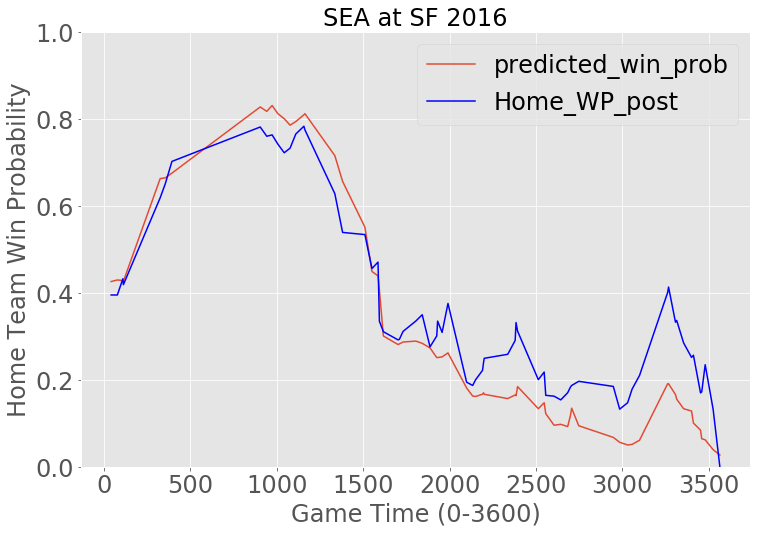

In [86]:
test_game1  = game_prob_df[(game_prob_df['GameID']== 2017010115) & (game_prob_df['posteam']=='SEA')]

plt.figure(figsize=(12,8))
plt.plot(3600-test_game1.TimeSecs, test_game1.predicted_win_prob)
plt.plot(3600-test_game1.TimeSecs, test_game1.Home_WP_post, c='b')
plt.title('SEA at SF 2016',fontsize=24)
plt.xlabel('Game Time (0-3600)',fontsize=24)
plt.ylim(0,1)
plt.ylabel('Home Team Win Probability',fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=24)

Text(0,0.5,'Home Team Win Probability')

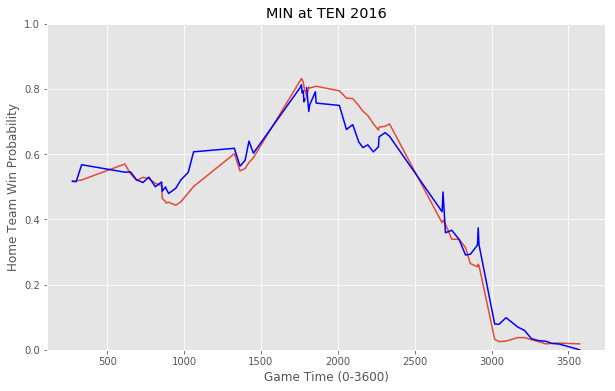

In [87]:
test_game2  = game_prob_df[(game_prob_df['GameID']== 2016091108) & (game_prob_df['posteam']=='MIN')]

plt.figure(figsize=(10,6))
plt.plot(3600-test_game2.TimeSecs, test_game2.predicted_win_prob)
plt.plot(3600-test_game2.TimeSecs, test_game2.Home_WP_post, c='b')
plt.title('MIN at TEN 2016')
plt.xlabel('Game Time (0-3600)')
plt.ylim(0,1)
plt.ylabel('Home Team Win Probability')

Text(0,0.5,'Home Team Win Probability')

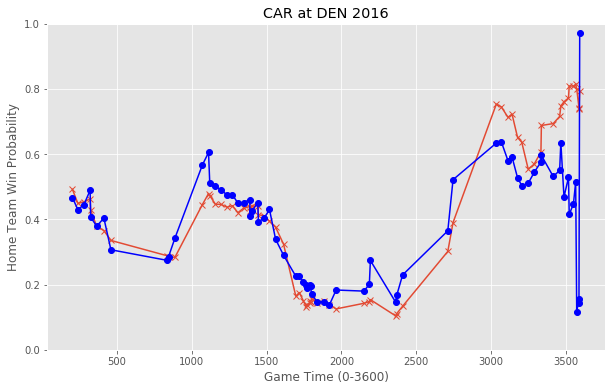

In [88]:


test_game3  = game_prob_df[(game_prob_df['GameID']== 2016090800) & (game_prob_df['posteam']=='CAR')]
plt.figure(figsize=(10,6))
plt.plot(3600-test_game3.TimeSecs, test_game3.predicted_win_prob, marker="x")
plt.plot(3600-test_game3.TimeSecs, test_game3.Home_WP_post, c='b',marker="o")
plt.title('CAR at DEN 2016')
plt.xlabel('Game Time (0-3600)')
plt.ylim(0,1)
plt.ylabel('Home Team Win Probability')

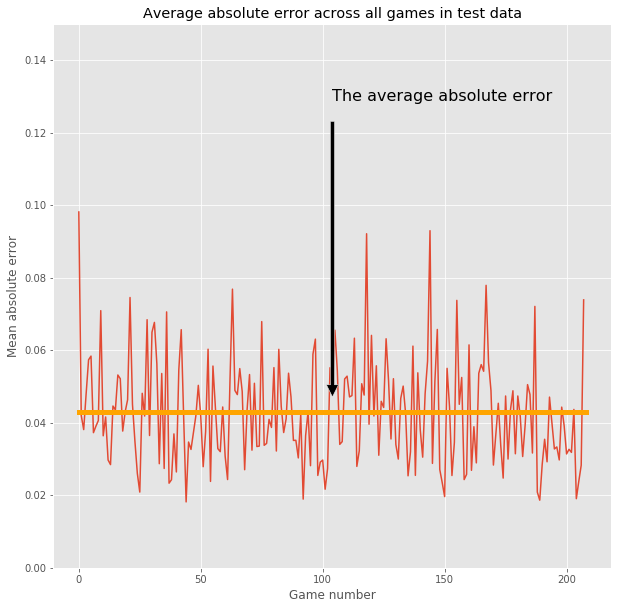

Overall average mean absolute error is: 0.04293163264131745
CPU times: user 2.46 s, sys: 14.8 ms, total: 2.48 s
Wall time: 2.48 s


In [101]:
%%time
#Check test data win probability accuracy
games = np.unique(game_prob_df.GameID)

abs_acc_per_game = []
for i in games:
    miniList = []
    game_frame_current = game_prob_df[game_prob_df.GameID==i]
    game_frame_current_subset = game_frame_current[game_frame_current.posteam==game_frame_current.AwayTeam]
    
    for j in range(0,game_frame_current_subset.shape[0]):
        cur_row = game_frame_current_subset.iloc[j]
        #Need to handle NaN values, do not average them
        if((cur_row.Home_WP_post <= 1) and (cur_row.Home_WP_post >= 0)):
            miniList.append(abs(cur_row.pred_win_prob-cur_row.Home_WP_post))
    abs_acc_per_game.append(np.mean(miniList))
        
plt.figure(figsize=(10,10))
plt.plot(range(0,len(games)), abs_acc_per_game)   
plt.title('Average absolute error across all games in test data')
plt.xlabel('Game number')
plt.ylim(0,.15)
plt.ylabel('Mean absolute error')
plt.annotate("The average absolute error",xy=(len(games)/2, np.mean(abs_acc_per_game)), xytext=(len(games)/2, np.mean(abs_acc_per_game)*3), arrowprops=dict(facecolor='black', shrink=0.05),size=16)
#plt.annotate("The average absolute error", xy=(0, 0))
plt.plot((0,len(games)),(np.mean(abs_acc_per_game),np.mean(abs_acc_per_game)),linewidth=5,c="orange")
plt.show()
print("Overall average mean absolute error is: " + str(np.mean(abs_acc_per_game)))

